# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import time

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


### **Question 1**
To convert a sampling rate from 48kHz to 32kHz, we need to Re-sample, with L=2 and M=3. H is a low-pass filter and its cut-off frequency is $\min({\frac{1}{2L}}{\frac{1}{2M}})$. The digital processing chain used will be :

↑L     H     ↓M

### **Question 2**

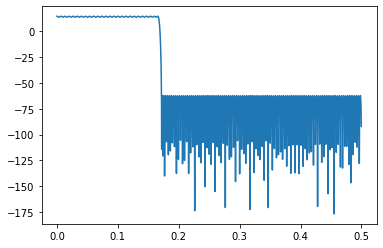

In [5]:
L=2
M=3
nu_c=min(1/(2*L),1/(2*M))
nu_a=nu_c+0.005
h = scipy.signal.remez(300,[0,nu_c,nu_a,.5],[L,0])

w, f = scipy.signal.freqz(h, [1], worN=2000, fs=1)
plt.plot(w,20*np.log(np.abs(f)))


In [6]:
play = False
if play :
    play_sound(sound) 

In [7]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [8]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

### **Question 3**

In [9]:
deb=time.time()

x_up=[0 for i in range(2*(len(x)))]
for i in range (len(x)):
    x_up[2*i]=x[i]

x_filt=scipy.signal.lfilter(h, [1,0], x_up, axis=-1, zi=None)

x_fin=[]


for i in range (len(x_filt)):
    if i%3==0:
        x_fin.append(x_filt[i])

print(time.time()-deb)
L=2
M=3

timestep_new = 1/float(Fs*(L/M))
times_new = np.arange(len(x_fin))*timestep_new

2.763712167739868


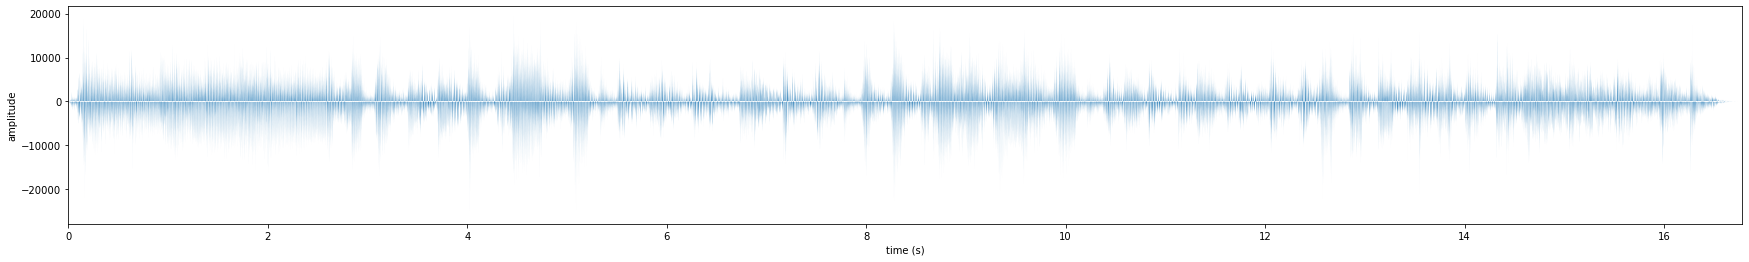

In [10]:
plot_sound(x, times)

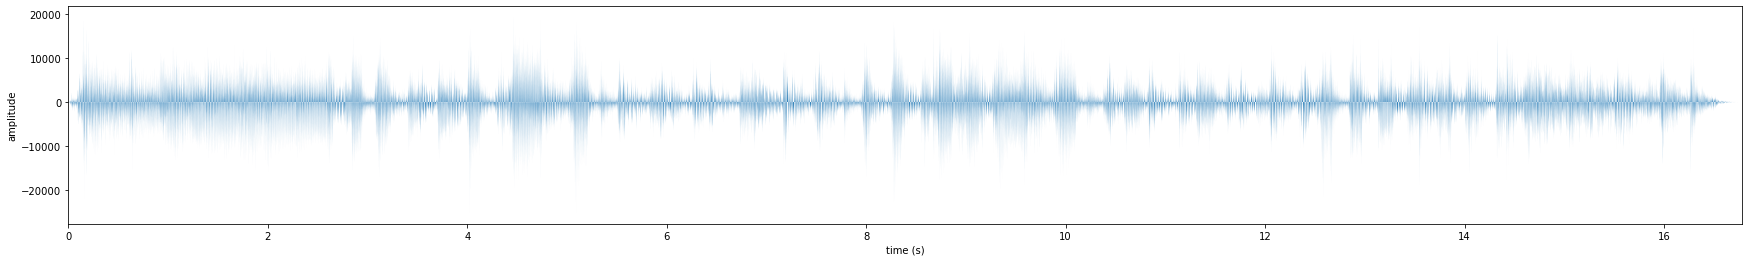

In [11]:
plot_sound(x_fin, times_new)

The signal after the digital processing chain is similar to the original one.

In [12]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

### **Question 4**

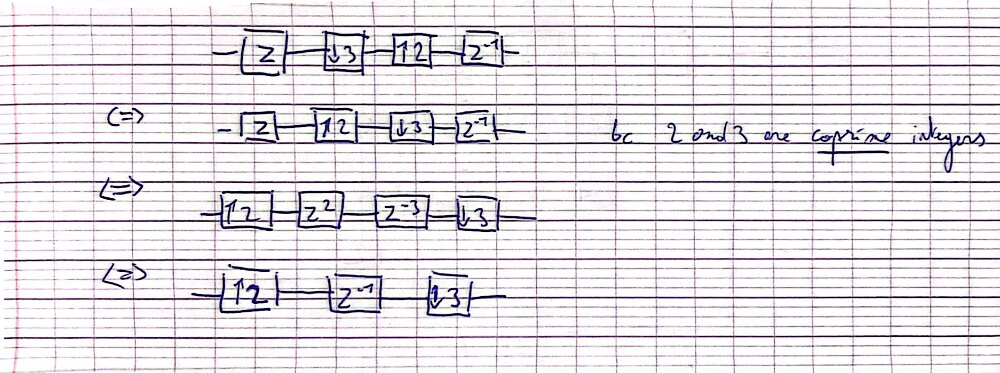

### **Question 5**

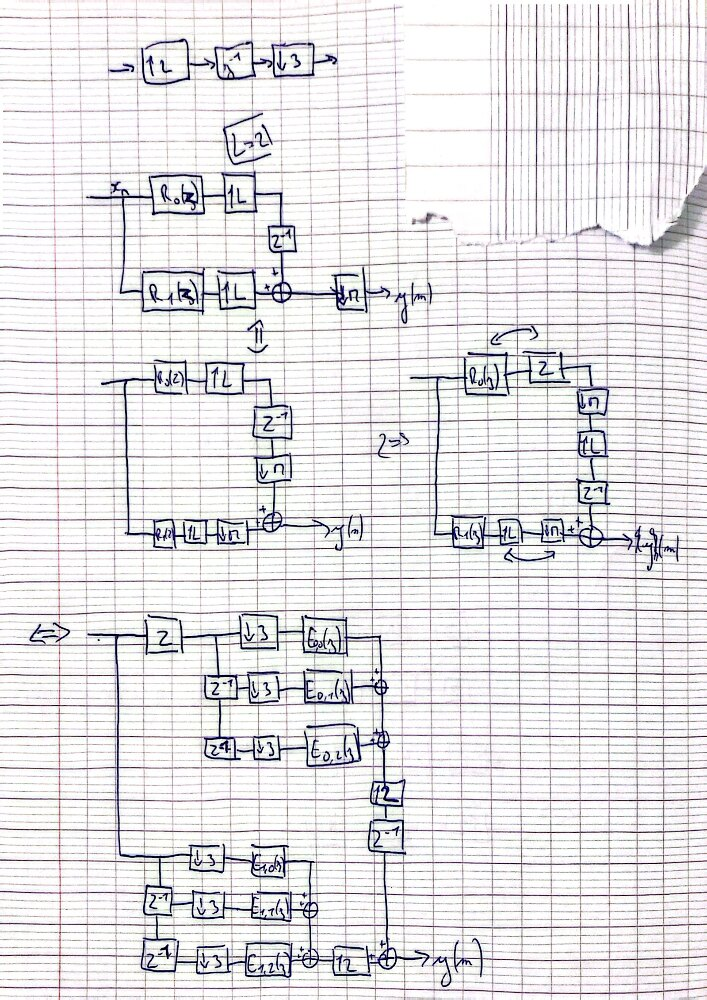

In [13]:
# Fonctions utiles

def décalage(x,n):
    if n>0:
        x1=n*[0]+x[0:len(x)-n]
    else:
        x1=x[(-n):len(x)]+(-n)*[0]
    return x1

def décimation(x,n):
    x1=[]
    for i in range (len(x)):
        if i%n==0:
            x1.append(x[i])
    return x1

def upsample(x,n):
    x1=[]
    for i in range (len(x)):
        x1.append(x[i])
        for j in range (n-1):
            x1.append(0)
    return x1

def filtre_RE(n,m,h):
    #n est le décalage recherché au départ, m est le pas de la décimation du filtre 
    #Attention: si filtre R, le décalage est inversé (si décimation de 2, pour obtenir R0, il faut prendre n=1)
    x_1=[]
    for i in range (len(h)):
        if i%m==n:
            x_1.append(h[i])
    return x_1

def deca_decim(x,x_z_boucle):
    for i in range(len(x)):
        if i%3==0:
            x_z_boucle[0].append(x[i])
        elif i%3==1:
            x_z_boucle[1].append(x[i])
        else:
            x_z_boucle[2].append(x[i])
    return x_z_boucle

def sum(x_z_boucle):
    x_z_boucle_sum=[]
    min_len=min(len(x_z_boucle[0]),len(x_z_boucle[1]),len(x_z_boucle[2]))
    for i in range(min_len):
        x_z_boucle_sum.append(x_z_boucle[0][i]+x_z_boucle[1][i]+x_z_boucle[2][i])
    return x_z_boucle_sum

In [14]:
#Création des filtres R et E

filtre=[[],[],[],
        [],[],[]]
for i in range (len(h)):
    if i%6==0:
        filtre[3].append(h[i])
    elif i%6==1:
        filtre[0].append(h[i])
    elif i%6==2:
        filtre[4].append(h[i])
    elif i%6==3:
        filtre[1].append(h[i])
    elif i%6==4:
        filtre[5].append(h[i])
    else:
        filtre[2].append(h[i])



In [15]:
deb=time.time()

#BOUCLE 1

x_z_boucle1=[[],[],[]]
x_z_boucle2=[[],[],[]]

    
x_z=décalage(x,1)
x_z_boucle1=deca_decim(x_z,x_z_boucle1)
for i in range(M):
    x_z_boucle1[i]=scipy.signal.lfilter(filtre[i], [1,0], x_z_boucle1[i], axis=-1, zi=None)
x1_fin=sum(x_z_boucle1)
x_boucle1=upsample(x1_fin,2)
x_boucle1=décalage(x_boucle1,-1)

#BOUCLE 2

x_z_boucle2=deca_decim(x,x_z_boucle2)
for i in range(M):
    x_z_boucle2[i]=scipy.signal.lfilter(filtre[3+i], [1,0], x_z_boucle2[i], axis=-1, zi=None)

x2_fin=sum(x_z_boucle2)
x_boucle2=upsample(x2_fin,2)
x_fin=[x_boucle2[i]+x_boucle2[i] for i in range(min(len(x_boucle2),len(x_boucle1)))]



print(time.time()-deb)


3.3372106552124023


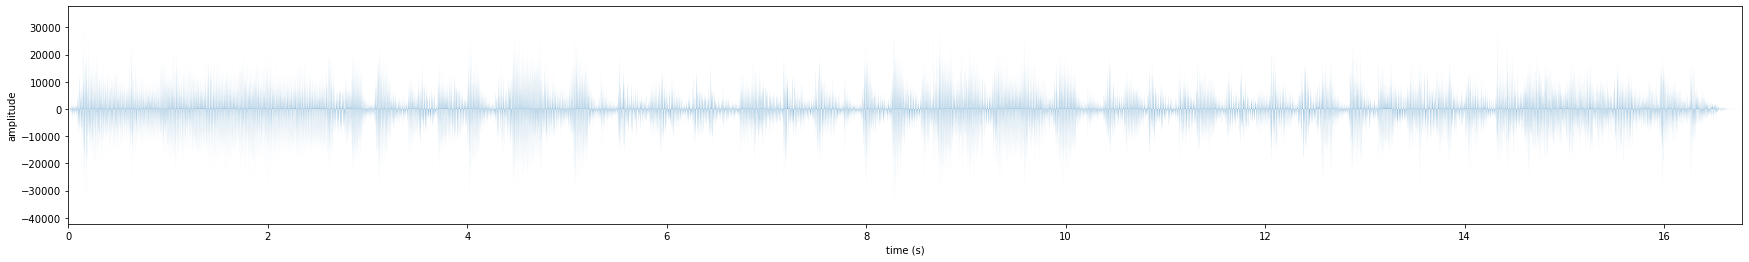

In [16]:
timestep_new = 1/float(Fs*(L/M))
times_new = np.arange(len(x_fin))*timestep_new
plot_sound(x_fin, times_new)

### **Question 6**


The results are graphicly very similar and we can't hear any differences in the audio.
The time needed should be smaller for the second method, however, we found a bigger time (around 0.2s longer). This could be due to the computer.

## Signal analysis with the STFT

In [17]:
N = x.shape[0] # % longueur du signal
Nw = 32
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = (M/2)+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

### **Question 1**

C:\Users\Louis\AppData\Local\Temp\ipykernel_16848\2560945798.py:6: RuntimeWarning: divide by zero encountered in log
  response = 20 * np.log(np.abs(W))


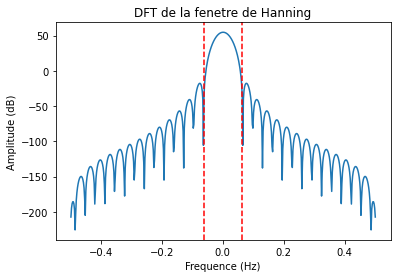

In [18]:
# Affichage DFT de la fenêtre

W = np.fft.fftshift(np.fft.fft(w, M))

freq = np.linspace(-0.5, 0.5, M)
response = 20 * np.log(np.abs(W))
plt.plot(freq, response)
plt.xlabel('Frequence (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('DFT de la fenetre de Hanning')
plt.axvline(-2.0/Nw,color = 'red', linestyle = '--')
plt.axvline(2.0/Nw,color = 'red', linestyle = '--')
plt.show()


Empirically, we have found that the main lobe width equals to $\frac{4}{Nw}$. The best result is obtained for Nw=32 and M=512

### **Question 2**

We have :
$$
W_x(\lambda,b) = e^{-2j\pi\lambda b}(x*h)(b)
$$

The Hann window is a band-pass filter, h is the impulse response of the band-pass filter.
As the filter is symmetrical, the type of the FIR filter is 2 or 4. The type between those two will depends on the length. The type will be 2 for even length and 4 for odd length.

### **Question 3**

We have:
$$
\tilde{X}(\lambda,b) = e^{2j\pi\lambda b}W_x(\lambda,b)
$$

This second definition of the STFT is called "band-pass convention" because whe shift the signal before applying the Hann window. We analyze diiferent frequency band explaining this designation.

In the notebook, we are using the band-pass version because the signal is shifted before being filtered.

### **Question 4**

[-13.35233688+5.7959177j  -16.27142688+6.58167994j
 -10.23887165+2.54209255j ...  -1.97665725+0.78764954j
  -1.6628839 +0.56084495j   0.53014667-0.60238285j]


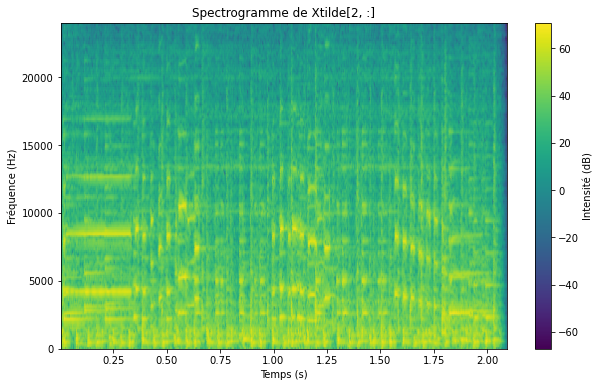

In [19]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

# Affichage du spectrogramme de la trame Xtilde[:, 3]
print(Xtilde[2,:])
frequencies, times, Sxx = scipy.signal.spectrogram(np.real(Xtilde[2,:]), fs=Fs)

# Affichage du spectrogramme
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.title('Spectrogramme de Xtilde[2, :]')
plt.colorbar(label='Intensité (dB)')
plt.show()




We can see that $x_k(u)=\tilde{X}(k,u)$ for k=3 is complex

In [20]:
write('new_caravan.wav', Fs, np.array(Xtilde[0,:], dtype=np.int16)) # to write a new wave file

C:\Users\Louis\AppData\Local\Temp\ipykernel_16848\242016869.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  write('new_caravan.wav', Fs, np.array(Xtilde[0,:], dtype=np.int16)) # to write a new wave file


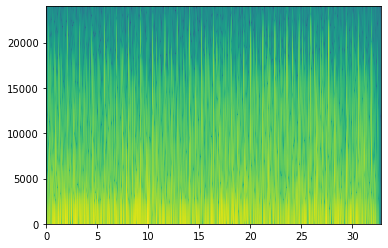

In [21]:
L=int(L)
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

## Overlap-add reconstruction

### **Question 5**

We have:
$$
\begin{align}
y(n)&= \sum_{u \in \mathbb{Z}} y_s(u,n - uR) \\
    &= \sum_{u \in \mathbb{Z}} w_s(n - uR) \frac{1}{M} \sum_{k=0}^{M-1}\tilde{X}(k,u)e^{j2\pi\frac{k(n-uR)}{M}}\\
    &= \sum_{u \in \mathbb{Z}} w_s(n - uR) \frac{1}{M} \sum_{k=0}^{M-1}(\sum_{l \in \mathbb{Z}} x(l+uR)w(l)e^{-j2\pi\frac{kl}{M}})e^{j2\pi\frac{k(n-uR)}{M}}\\
    &= \sum_{u \in \mathbb{Z}} w_s(n - uR) \frac{1}{M} \sum_{k=0}^{M-1}(\sum_{l \in \mathbb{Z}} x(l)w(l-uR)e^{-j2\pi\frac{kl}{M}})e^{j2\pi\frac{kuR}{M}}e^{j2\pi\frac{k(n-uR)}{M}}\\
    &= \sum_{u \in \mathbb{Z}} w_s(n - uR) \frac{1}{M} \sum_{l \in \mathbb{Z}}x(l)w(l-uR)(\sum_{k=0}^{M-1} e^{-j2\pi\frac{k(l-n)}{M}}) \\
    &= \sum_{u \in \mathbb{Z}}w_s(n-uR)x(n)w(n-uR)
\end{align}
$$
On passe de (5) à (6) avec la somme des racines de l'unité qui vaut 0 si n différent de l et vaut M si l=n

we have then :
$$
y(n)= x(n) \Leftrightarrow \sum_{u \in \mathbb{Z}}w_s(n-uR)w(n-uR) = 1 = f(n)

In [22]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

[[0.00000000e+00]
 [7.19849713e-05]
 [1.12830361e-03]
 ...
 [1.12830361e-03]
 [7.19849713e-05]
 [0.00000000e+00]]


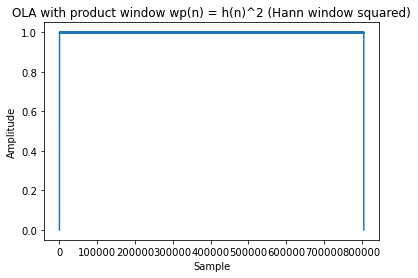

In [23]:
w=np.hanning(Nw)
ws=w.copy()
output = ola(np.multiply(w,ws), int(R), Nt)
output/=max(output)  #normalization
print(output)
plt.figure()
plt.plot(output)
plt.title("OLA with product window wp(n) = h(n)^2 (Hann window squared)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

### **Question 6**

In [26]:
Nw=32
M=32
w=np.hanning(Nw)

def STFT(x, w, Nw, M):
    N = x.shape[0]
    R = Nw // 4
    Nt = int(np.floor((N - Nw) / R))  # Define Nt correctly
    y = np.zeros(Nw + R * Nt)
    for u in range(Nt):  # boucle sur les trames
        deb = int(u * R)  # début de trame
        fin = int(deb + Nw)  # fin de trame
        tx = np.multiply(x[deb:fin], w)  # calcul de la trame 
        X = np.fft.fft(tx, M)  # tfd à l'instant b
        Y = X.copy()
        ty = np.fft.ifft(Y, Nw)
        ty = np.multiply(ty, w)
        y[u * R:u * R + Nw] += np.real(ty)  
    return y

y=STFT(x, w, Nw, M)


In [27]:
write('new_caravan.wav', Fs, np.array(y, dtype=np.int16))  # to write a new wave file

In [ ]:
def mse(x, y):
    # Tronquer les signaux à la même longueur
    min_len = min(len(x), len(y))
    x = x[:min_len]
    y = y[:min_len]
    
    # Calcul de l'erreur quadratique moyenne
    mse_value = np.mean((x - y) ** 2)
    return mse_value

x = x.astype(float)  # Convert x to float type
x /= max(x)
y /= max(y)

print(mse(x, y))

Après normalisation, on a une erreur quadratique moyenne très faible ce qui indique une très bonne resynthèse et des signaux d'entrée et de sortie similaire. Cela se retrouve quand on écoute les sons qui sont les mêmes.

### **Question 7**

In [25]:
def STFT_equalizer(x, w, Nw, M,equalizer):
    N = x.shape[0]
    R = Nw // 4
    Nt = int(np.floor((N - Nw) / R))  # Define Nt correctly
    y = np.zeros(Nw + R * Nt)
    for u in range(Nt):  # boucle sur les trames
        deb = int(u * R)  # début de trame
        fin = int(deb + Nw)  # fin de trame
        tx = np.multiply(x[deb:fin], w)  # calcul de la trame 
        X = np.fft.fft(tx, M)  # tfd à l'instant b
        Y = X.copy()
        Y=np.multiply(Y,equalizer)
        ty = np.fft.ifft(Y, M)
        ty = np.multiply(ty, w)
        y[u * R:u * R + Nw] += np.real(ty)    
    return y

y=STFT_equalizer(x, w, Nw, M,[2,2,2,2,2,2]+[1]*26)

write('new_caravan.wav', Fs, np.array(y, dtype=np.int16))

On implémente l'equalizer en multipliant chaque trame par un equalizer qu'on fourni dans la fonction. En mettant des deux au début de la liste et des 1 après, on amplifie les basses ce que l'on peut d'ailleurs très bien observés dans le son final.